In [1]:
pip install yfinance

     ---------------------------------------- 0.0/314.6 kB ? eta -:--:--
     --- --------------------------------- 30.7/314.6 kB 660.6 kB/s eta 0:00:01
     ----------- --------------------------- 92.2/314.6 kB 1.1 MB/s eta 0:00:01
     --------------------- ---------------- 174.1/314.6 kB 1.3 MB/s eta 0:00:01
     ---------------------------- --------- 235.5/314.6 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 314.6/314.6 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
      --------------

In [2]:
import yfinance as yf

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data = yf.download('ESCORTS.NS',period='5y',interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [5]:
data.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-22,653.950012,661.500000,648.599976,655.599976,644.549133,1323912
2019-02-25,655.599976,661.799988,645.500000,654.450012,643.418579,964200
2019-02-26,649.200012,668.000000,633.500000,660.900024,649.759827,1754000


In [6]:
data_target = data.iloc[:1182,4]
data_test = data.iloc[1132:,4]
data = data.loc[:,["Adj Close"]].values

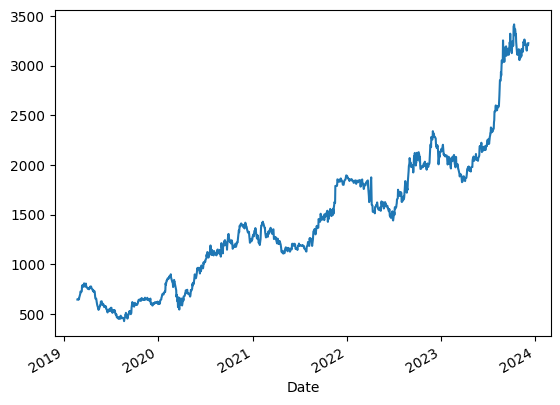

In [7]:
plot = data_target.plot()

In [8]:
#Check Length 
print("Length of Data:{}".format(len(data)))
print("Length of Data_Target:{}".format(len(data_target)))

Length of Data:1235
Length of Data_Target:1182


In [9]:
#Scaling Dataset
def scaledata(data_target):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1))
    data_target_scaled = scaler.fit_transform(np.array(data_target).reshape(-1,1))
    #plot_scaled = pd.DataFrame(data_target_scaled).plot()
    print(data_target.shape)
    return data_target_scaled, scaler

In [10]:
data_target_scaled = scaledata(data_target)[0]
scaler = scaledata(data_target)[1]
data_target_scaled

(1182,)
(1182,)


array([[0.07273119],
       [0.07235262],
       [0.07447599],
       ...,
       [0.93294615],
       [0.92927955],
       [0.93679693]])

In [11]:
data_test_scaled = scaledata(data_test)[0]

(103,)


In [12]:
#Create pattern and end price set
def createPatternSet(data_target_scaled,steps=7):   
    x_patern = []
    y_price = []

    for day in range(steps,data_target_scaled.shape[0]):
        row = data_target_scaled[day-steps:day,0]
        #print(len(row))
        x_patern.append(row)
        y = data_target_scaled[day,0]
        #print(y)
        y_price.append(y)
    
    x_patern,y_price = np.array(x_patern),np.array(y_price)
    x_patern = x_patern.reshape(x_patern.shape[0],x_patern.shape[1],1)
    
    return x_patern,y_price

In [13]:
train_pattern = createPatternSet(data_target_scaled,steps=50)

In [14]:
x_train = train_pattern[0]
y_train = train_pattern[1]

In [15]:
x_train.shape

(1132, 50, 1)

In [16]:
y_train.shape

(1132,)

In [17]:
x_train

array([[[0.07273119],
        [0.07235262],
        [0.07447599],
        ...,
        [0.05766998],
        [0.0537689 ],
        [0.04543998]],

       [[0.07235262],
        [0.07447599],
        [0.07528254],
        ...,
        [0.0537689 ],
        [0.04543998],
        [0.04532475]],

       [[0.07447599],
        [0.07528254],
        [0.07338959],
        ...,
        [0.04543998],
        [0.04532475],
        [0.03795053]],

       ...,

       [[0.91843034],
        [0.9072296 ],
        [0.89746874],
        ...,
        [0.91948517],
        [0.9117836 ],
        [0.93016687]],

       [[0.9072296 ],
        [0.89746874],
        [0.9038309 ],
        ...,
        [0.9117836 ],
        [0.93016687],
        [0.93294615]],

       [[0.89746874],
        [0.9038309 ],
        [0.9401622 ],
        ...,
        [0.93016687],
        [0.93294615],
        [0.92927955]]])

In [18]:
class StocksPriceRNN():

    loss='mean_squared_error'
    batch_size=32
    neurons = 50
    model = tf.keras.Sequential()
    def __init__(self,x_train,y_train,epoch):
        self.x_train = x_train
        self.y_train = y_train
        self.epoch = epoch
    
    def buildArchitecture(self,rnn=2,dense=1):
        StocksPriceRNN.model = tf.keras.Sequential()
        StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                            activation='tanh',
                                            return_sequences = True,
                                            input_shape = (self.x_train.shape[1],1)))
        StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))
        for i in range(rnn):
            StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                                activation='tanh',
                                                return_sequences = True))
            StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))
        
        #return sequense changed to false
        StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                                activation='tanh',
                                                return_sequences = False))
        StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))
        
        for i in range(dense):
            StocksPriceRNN.model.add(tf.keras.layers.Dense(units=StocksPriceRNN.neurons,
                                            activation='tanh'))
        
        #Output
        StocksPriceRNN.model.add(tf.keras.layers.Dense(units=1))
        return StocksPriceRNN.model.summary()
    
    def compiler(self):
        opt= tf.keras.optimizers.Adam()
        StocksPriceRNN.model.compile(optimizer = opt,
                                    loss = StocksPriceRNN.loss)
        return StocksPriceRNN.model.summary()
        
    def modelfit(self):
        history = StocksPriceRNN.model.fit(self.x_train,self.y_train,
                                        epochs=self.epoch,batch_size=StocksPriceRNN.batch_size,validation_split=0.2,
                                       )
        return history
    
    def changeBatchSize(self,size):
        StocksPriceRNN.batch_size = size
        print("Changed!")
    def changeNeurons(self,size):
        StocksPriceRNN.neurons = size
        print("Changed!")
    def changeEpoch(self,size):
        self.epoch = size
        print("Changed!")

In [19]:
RNN1 = StocksPriceRNN(x_train,y_train,50)

In [20]:
RNN1.buildArchitecture(2,0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)               

In [21]:
RNN1.compiler()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)               

In [22]:
history = RNN1.modelfit()

Epoch 1/50
29/29 [==============================] - 15s 333ms/step - loss: 0.3300 - val_loss: 0.0750
Epoch 2/50
29/29 [==============================] - 1s 44ms/step - loss: 0.2034 - val_loss: 0.0462
Epoch 3/50
29/29 [==============================] - 1s 43ms/step - loss: 0.1451 - val_loss: 0.0102
Epoch 4/50
29/29 [==============================] - 1s 40ms/step - loss: 0.1098 - val_loss: 0.0195
Epoch 5/50
29/29 [==============================] - 1s 41ms/step - loss: 0.0935 - val_loss: 0.0265
Epoch 6/50
29/29 [==============================] - 1s 43ms/step - loss: 0.0632 - val_loss: 0.0154
Epoch 7/50
29/29 [==============================] - 1s 40ms/step - loss: 0.0550 - val_loss: 0.0041
Epoch 8/50
29/29 [==============================] - 1s 40ms/step - loss: 0.0508 - val_loss: 0.0082
Epoch 9/50
29/29 [==============================] - 1s 39ms/step - loss: 0.0398 - val_loss: 0.0070
Epoch 10/50
29/29 [==============================] - 1s 39ms/step - loss: 0.0334 - val_loss: 0.0030
Epoch 1

In [23]:
#Prepare Test Data
test = data[len(data) - len(data_test) - 50:]
test = scaler.transform(test)

In [24]:
test_pattern = createPatternSet(test,steps=50)
x_test = test_pattern[0]
y_test = test_pattern[1]

In [25]:
#Predict the value for test set
y_test

array([0.9038309 , 0.9401622 , 0.93254435, 0.96862451, 0.93053524,
       0.92343642, 0.90319463, 0.92691884, 0.94280749, 0.92648352,
       0.92877728, 0.99320251, 0.99537904, 1.        , 0.98829698,
       0.98389365, 0.97530476, 0.96115732, 0.96713444, 0.94074819,
       0.90639247, 0.89726779, 0.90617485, 0.9104442 , 0.91645475,
       0.90582324, 0.88097734, 0.87980536, 0.88705485, 0.88817663,
       0.90344577, 0.9104442 , 0.8926134 , 0.91734208, 0.90754769,
       0.90794958, 0.92398889, 0.94156856, 0.93518963, 0.9490525 ,
       0.93070267, 0.93590961, 0.938287  , 0.92715322, 0.91948517,
       0.9117836 , 0.93016687, 0.93294615, 0.92927955, 0.93679693,
       0.94672522, 0.91010935, 0.91858109, 0.9026254 , 0.90371367,
       0.9100424 , 0.90505307, 0.90652646, 0.89458899, 0.85505985,
       0.85638257, 0.85037194, 0.85365349, 0.84695648, 0.84782712,
       0.85579658, 0.85018784, 0.82383502, 0.81787474, 0.8140574 ,
       0.79610945, 0.81261752, 0.80232086, 0.80620517, 0.81553

In [26]:
x_test

array([[[0.63297013],
        [0.6328027 ],
        [0.65275984],
        ...,
        [0.91843034],
        [0.9072296 ],
        [0.89746874]],

       [[0.6328027 ],
        [0.65275984],
        [0.64865792],
        ...,
        [0.9072296 ],
        [0.89746874],
        [0.9038309 ]],

       [[0.65275984],
        [0.64865792],
        [0.64229575],
        ...,
        [0.89746874],
        [0.9038309 ],
        [0.9401622 ]],

       ...,

       [[0.94672522],
        [0.91010935],
        [0.91858109],
        ...,
        [0.82951081],
        [0.83701143],
        [0.84834616]],

       [[0.91010935],
        [0.91858109],
        [0.9026254 ],
        ...,
        [0.83701143],
        [0.84834616],
        [0.83729608]],

       [[0.91858109],
        [0.9026254 ],
        [0.90371367],
        ...,
        [0.84834616],
        [0.83729608],
        [0.83270856]]])

In [27]:
pred = RNN1.model.predict(x=x_test)
pred.shape

4/4 [==============================] - 0s 5ms/step


(103, 1)

In [28]:
#Transform back the inverse value

output = scaler.inverse_transform(pred)
org_vals = scaler.inverse_transform(y_test.reshape(-1,1))

In [29]:
output

array([[2770.6106],
       [2759.7537],
       [2758.942 ],
       [2781.4636],
       [2807.6865],
       [2825.2812],
       [2827.409 ],
       [2797.0647],
       [2773.3071],
       [2781.2344],
       [2795.1895],
       [2812.6008],
       [2816.339 ],
       [2845.8684],
       [2876.3691],
       [2893.6426],
       [2882.6086],
       [2887.3298],
       [2895.7285],
       [2875.6052],
       [2844.7078],
       [2813.4863],
       [2791.9685],
       [2763.7532],
       [2750.8313],
       [2770.9487],
       [2780.0889],
       [2756.1377],
       [2737.1096],
       [2723.8572],
       [2731.432 ],
       [2733.4944],
       [2752.0127],
       [2770.73  ],
       [2771.401 ],
       [2768.3743],
       [2767.2   ],
       [2780.678 ],
       [2802.8413],
       [2811.8809],
       [2820.107 ],
       [2820.4204],
       [2810.782 ],
       [2809.269 ],
       [2813.579 ],
       [2821.6455],
       [2804.5598],
       [2792.927 ],
       [2799.5503],
       [2800.227 ],


In [30]:
def plotting(org_vals,output):
    plt.figure(figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(org_vals,color="Green",label="Org value")
    plt.plot(output,color="Yellow",label="Predicted")
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

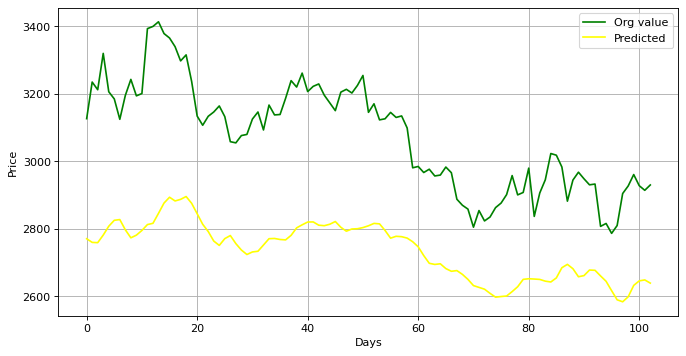

In [31]:
plotting(org_vals,output)